In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [4]:
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [62]:
IMAGE_SIZE = 227
BATCH_SIZE = 32
EPOCHS = 30

# Loading the Dataset

In [63]:
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/ML Implementation/Corn-disease/corn_disease_dataset/data",
     shuffle = True,
     seed=SEED,
     image_size = (IMAGE_SIZE, IMAGE_SIZE),
     batch_size = BATCH_SIZE
)

Found 4814 files belonging to 4 classes.


In [64]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [65]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 227, 227, 3)
[3 2 1 2 1 1 0 3 0 1 1 1 1 1 2 2 3 2 0 2 2 0 2 1 3 1 0 1 2 1 1 2]


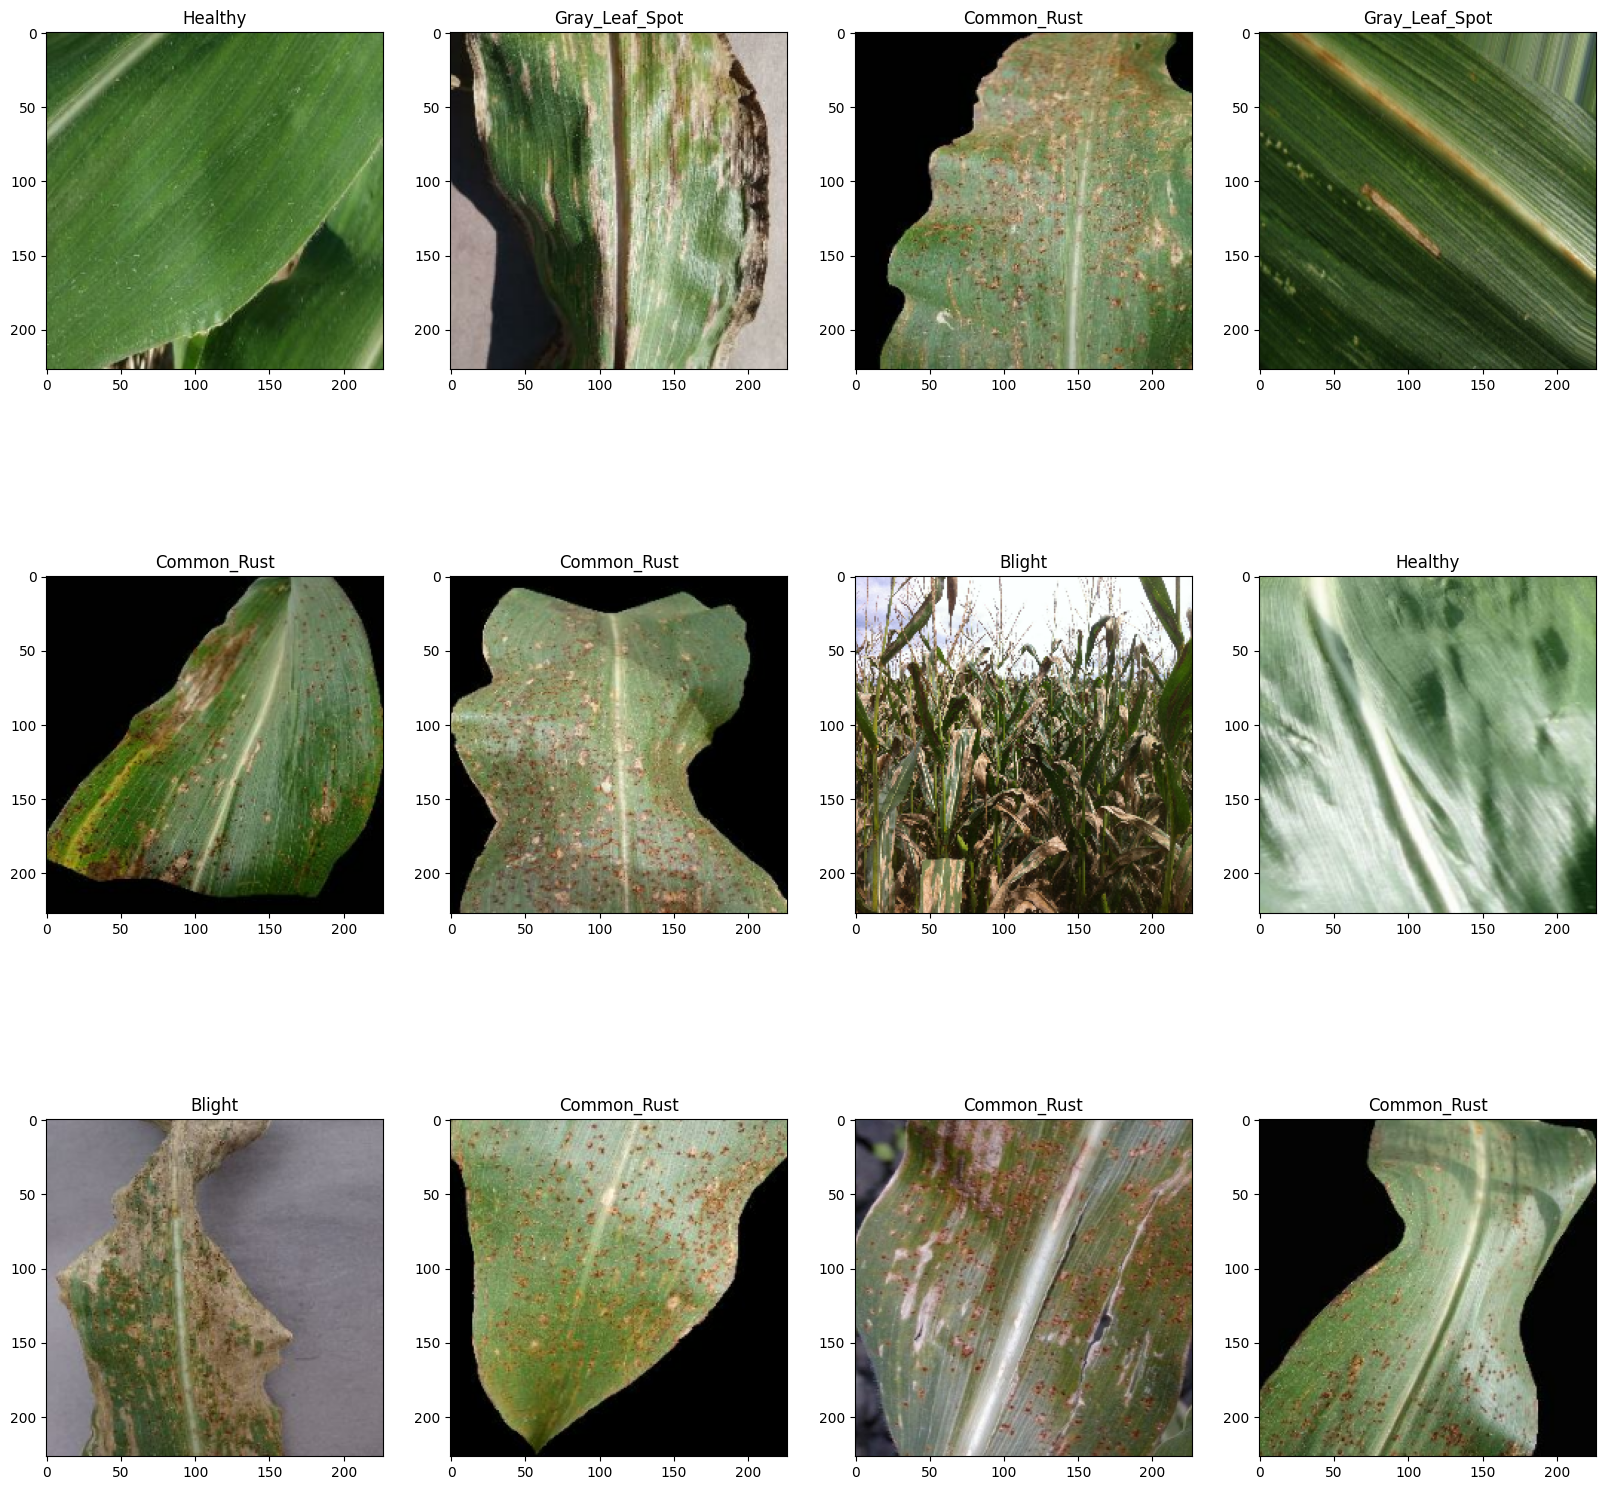

In [66]:
plt.figure(figsize = (20,20)) # Lets increse plot size of our plots
#Lets explore our batch and display some images
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
    #To visualize all images plot as subplot 
        ax = plt.subplot(3,4,i+1)
    #Visualize image using matplotlib imshow function plt.imshow expects a 3D numpy array
        plt.title(class_names[label_batch[i]]) # Displaying its class label as title
        plt.imshow(image_batch[i].numpy().astype('uint8'))
    print(image_batch.shape)
    print(label_batch.numpy())

In [67]:
y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))#np.bincount(array) counts occurence of each element in array.

[1146 1306 1200 1162]


# Data Partition

In [68]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Count dataset size
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [69]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [70]:
len(train_ds)

120

In [71]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Rescaling & Augmentation

In [51]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])


In [52]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [72]:
# Train: resize → augment → cache → prefetch
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [73]:
# Val/test: resize → cache → prefetch (no augmentation)
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [80]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers, optimizers

In [85]:
# Instantiate model
model = tf.keras.models.Sequential(name="Alexnet")

model.add(layers.Conv2D(96, (11,11), strides=(4,4), padding='valid', 
                        kernel_regularizer=regularizers.l2(0.001), input_shape=(227,227,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (5,5), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(384, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(384, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))  # 4 classes

model.summary()

# Compile
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Model: "Alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 activation_51 (Activation)  (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 27, 27, 96)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_51 (Ba  (None, 27, 27, 96)        384       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 27, 27, 96)        0         
                                                                 
 conv2d_52 (Conv2D)          (None, 27, 27, 256)       6146

In [93]:
# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_ckpt = callbacks.ModelCheckpoint(
    filepath="best_alexnet.h5",  # or best_alexnet.keras if using latest version
    save_best_only=True,
    monitor="val_loss"
)

In [94]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 1/20
120/120 [==============================] - 99s 820ms/step - loss: 1.3690 - accuracy: 0.8082 - val_loss: 2.9325 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 119s 993ms/step - loss: 1.1965 - accuracy: 0.8129 - val_loss: 1.4092 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 110s 916ms/step - loss: 1.2121 - accuracy: 0.8155 - val_loss: 1.3275 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 115s 962ms/step - loss: 1.0022 - accuracy: 0.8127 - val_loss: 1.2256 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 116s 963ms/step - loss: 0.9225 - accuracy: 0.8260 - val_loss: 1.9540 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 115s 960ms/step - loss: 0.8277 - accuracy: 0.8205 - val_loss: 0.9493 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 7/20
120/120 [===========================

In [95]:
initial_epochs = 20
new_epochs = 10
total_epochs = initial_epochs + new_epochs

In [97]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 20/30
120/120 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.8639

C:\ML Implementation\Corn-disease\corn_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


120/120 [==============================] - 124s 1s/step - loss: 0.5203 - accuracy: 0.8639 - val_loss: 0.7744 - val_accuracy: 0.8729 - lr: 4.0000e-05
Epoch 21/30
120/120 [==============================] - 123s 1s/step - loss: 0.5083 - accuracy: 0.8642 - val_loss: 0.7642 - val_accuracy: 0.8750 - lr: 4.0000e-05
Epoch 22/30
120/120 [==============================] - 118s 985ms/step - loss: 0.5023 - accuracy: 0.8689 - val_loss: 0.7379 - val_accuracy: 0.8833 - lr: 4.0000e-05
Epoch 23/30
120/120 [==============================] - 118s 985ms/step - loss: 0.4862 - accuracy: 0.8668 - val_loss: 0.7291 - val_accuracy: 0.8750 - lr: 4.0000e-05
Epoch 24/30
120/120 [==============================] - 118s 983ms/step - loss: 0.4899 - accuracy: 0.8755 - val_loss: 0.7173 - val_accuracy: 0.8771 - lr: 4.0000e-05
Epoch 25/30
120/120 [==============================] - 119s 987ms/step - loss: 0.4714 - accuracy: 0.8807 - val_loss: 0.6920 - val_accuracy: 0.8750 - lr: 4.0000e-05
Epoch 26/30
120/120 [=============

In [98]:
acc = history.history['accuracy'] +history_1.history['accuracy']
val_acc = history.history['val_accuracy'] +  history_1.history['val_accuracy']

loss = history.history['loss'] + history_1.history['loss']
val_loss = history.history['val_loss'] +  history_1.history['val_loss']

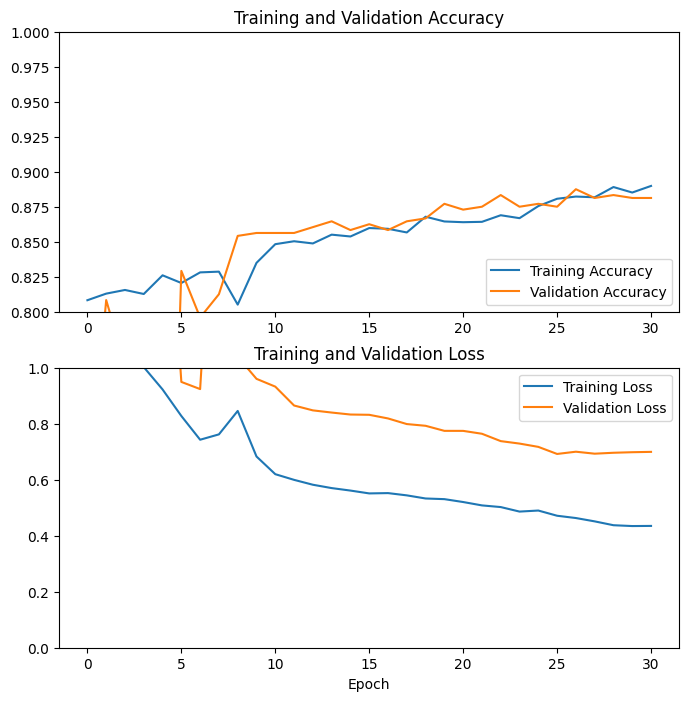

In [100]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

first image to print


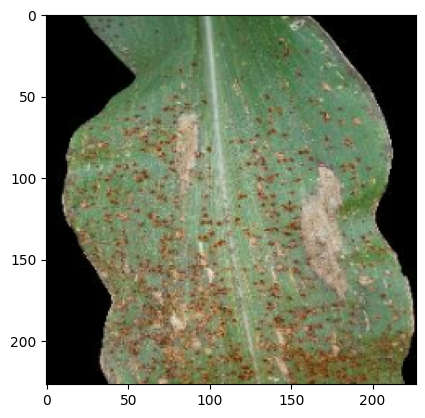

first image actual label: Common_Rust
1/1 [==============================] - 1s 893ms/step
predicted label: Common_Rust


In [101]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to print")
    plt.imshow(first_image)
    plt.show()

    print("first image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [102]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 56ms/step


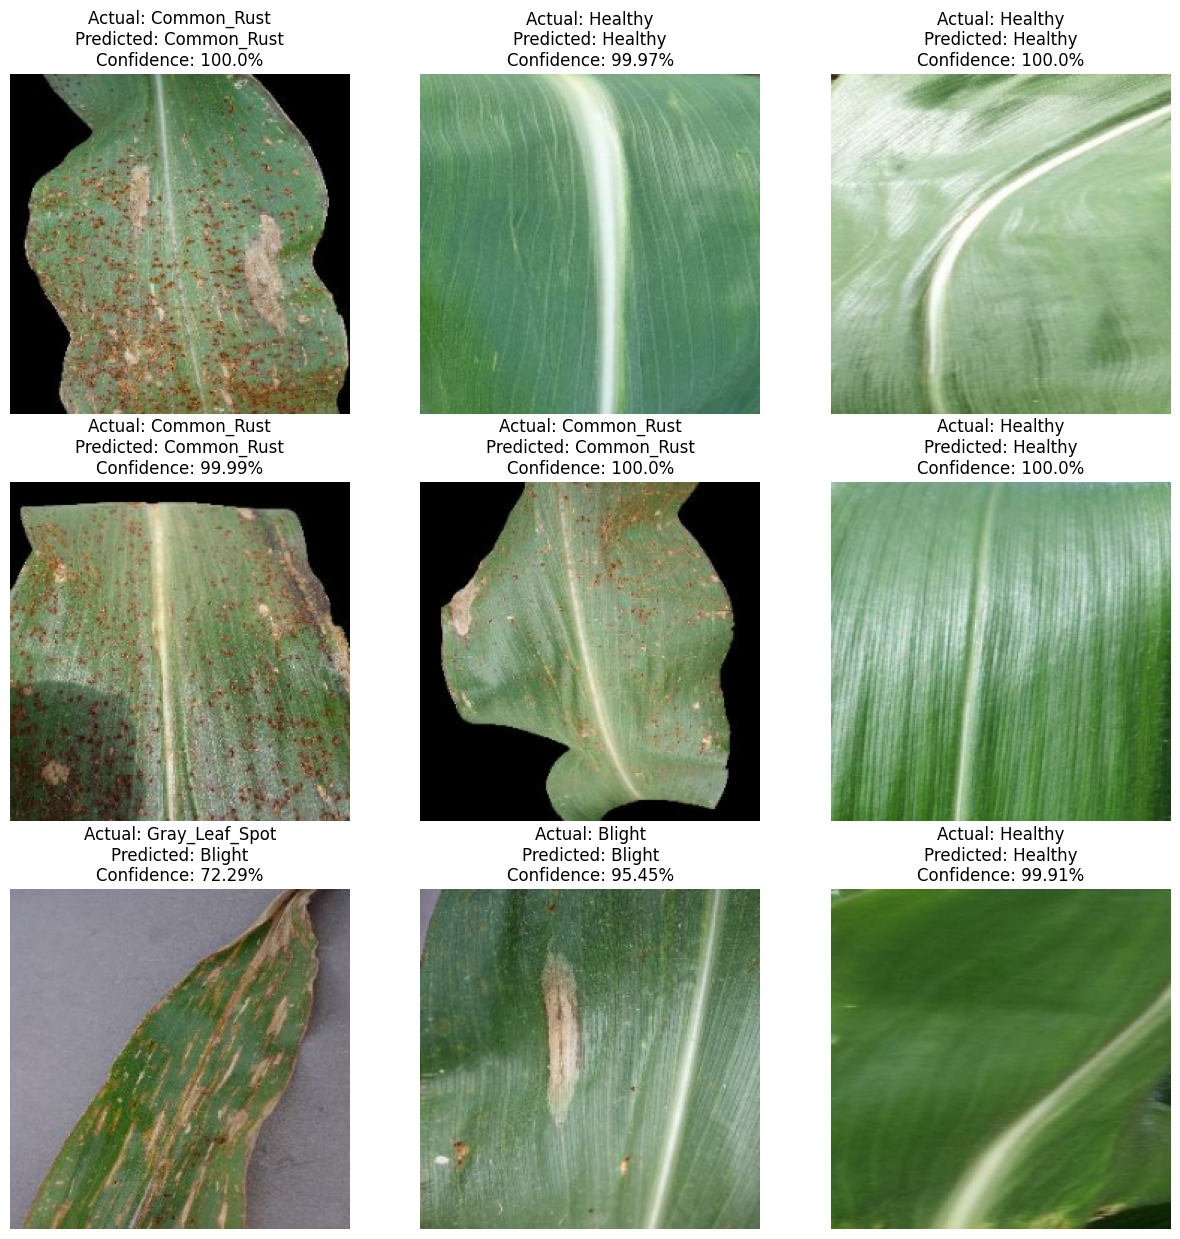

In [103]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")


# Model Predictions

In [104]:
import numpy as np

y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()             # shape (batch_size,)
    

    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)
    
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)  

1/1 [==============================] - 0s 326ms/step


In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Accuracy

In [106]:
acc = accuracy_score(y_true, y_pred)

In [108]:
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 87.50%


# Precision

In [109]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'

In [110]:
print(f"Precision: {precision * 100:.2f}%")

Precision: 88.05%


# Recall

In [111]:
recall = recall_score(y_true, y_pred, average='weighted')

In [112]:
print(f"Recall: {recall * 100:.2f}%")

Recall: 87.50%


# F1-Score

In [113]:
f1 = f1_score(y_true, y_pred, average='weighted')

In [114]:
print(f"f1: {f1 * 100:.2f}%")

f1: 87.69%


# Confusion Matrix

In [115]:
cm = confusion_matrix(y_true, y_pred)

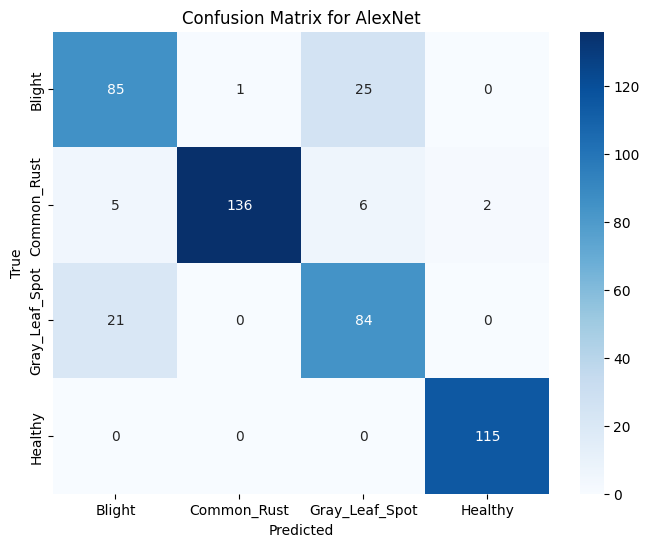

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for AlexNet')
plt.show()


# AUROC

In [117]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)


Macro-Averaged ROC-AUC Score: 97.71%


In [118]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\ML Implementation\Corn-disease


In [119]:
model_version= "AlexNet_227"
model.save(f"./models/{model_version}.keras")